In [1]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.manifold import MDS

import numpy as np
import os

from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D

# to make this notebook's output stable across runs
np.random.seed(42)

In [2]:
# 准备3d数据集
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)
X3D_inv = pca.inverse_transform(X2D)

axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

# 08. 降维
很多机器学习的问题都会涉及到有着几千甚至数百万维的特征的训练实例。这不仅让训练过程变得非常缓慢，同时还很难找到一个很好的解，我们接下来就会遇到这种情况。这种问题通常被称为`维数灾难`(curse of dimentionality)。

幸运的是，在现实生活中我们经常可以极大的降低特征维度，将一个十分棘手的问题转变成一个可以较为容易解决的问题。例如，对于`MNIST图片集`(第3章中提到)：图片四周边缘部分的像素几乎总是白的，因此你完全可以将这些像素从你的训练集中扔掉而不会丢失太多信息。`图7-6`向我们证实了这些像素的确对我们的分类任务是完全不重要的。同时，两个相邻的像素往往是高度相关的：如果你想要将他们合并成一个像素(比如取这两个像素点的平均值)你并不会丢失很多信息。

<img src="images/07_06.png" style="width:500px;"/>

> **警告**
> 降维肯定会丢失一些信息(这就好比将一个图片压缩成JPEG的格式会降低图像的质量)，因此即使这种方法可以加快训练的速度，同时也会让你的系统表现的稍微差一点。降维会让你的工作流水线更复杂因而更难维护。所有你应该先尝试使用原始的数据来训练，如果训练速度太慢的话再考虑使用降维。在某些情况下，降低训练集数据的维度可能会筛选掉一些噪音和不必要的细节，这可能会让你的结果比降维之前更好(这种情况通常不会发生；它只会加快你训练的速度)。

降维除了可以加快训练速度外，在数据可视化方面(或者DataViz)也十分有用。降低特征维度到2维(或者3)，从而可以在图中画出一个高维度的训练集，让我们可以通过视觉直观的发现一些非常重要的信息，比如聚类。

在这一章里，我们将会讨论维数灾难问题并且了解在高维空间的数据。然后，我们将会展示两种主要的降维方法：`投影`(projection)和`流形学习`(Manifold Learning)，同时我们还会介绍三种流行的降维技术：主成分分析(PCA)，核主成分分析(Kernel PCA)和局部线性嵌入(LLE)。

## 8.1 维数灾难
我们已经习惯生活在一个三维的世界里，以至于当我们尝试想象更高维的空间时，我们的直觉不管用了。即使是一个基本的4D超正方体也很难在我们的脑中想象出来(见`图8-1`)，更不用说一个200维的椭球弯曲在一个1000维的空间里了。

<img src="images/08_01.png" style="width:500px;"/>

这表明很多物体在高维空间表现的十分不同。比如，如果你在一个正方形单元中随机取一个点(一个$1×1$的正方形)，那么随机选的点离所有边界大于$0.001$(靠近中间位置)的概率为$0.4%$($1-0.998^2$)。换句话说，一个随机产生的点不大可能严格落在某一个维度上。但是在一个$10000$维的单位超正方体(一个$1×1×...×1$的立方体，有$10000$个$1$)，这种可能性超过了$99.999999%$。在高维超正方体中，大多数点都分布在边界处。

还有一个更麻烦的区别：如果你在一个平方单位中随机选取两个点，那么这两个点之间的距离平均约为$0.52$。如果您在单位3D立方体中选取两个随机点，平均距离将大致为$0.66$。但是，在一个$1,000,000$维超立方体中随机抽取两点呢？那么，平均距离，信不信由你，大概为$408.25$(大致$\sqrt{1,000,000/6}$)！

这非常违反直觉：当它们都位于同一单元超立方体内时，两点是怎么距离这么远的？这一事实意味着高维数据集有很大风险分布的非常稀疏：大多数训练实例可能彼此远离。当然，这也意味着一个新实例可能远离任何训练实例，这使得预测的可靠性远低于我们处理较低维度数据的预测，因为它们将基于更大的推测(extrapolations)。简而言之，训练集的维度越高，过拟合的风险就越大。

理论上来说，维数爆炸的一个解决方案是增加训练集的大小从而达到拥有足够密度的训练集。不幸的是，在实践中，达到给定密度所需的训练实例的数量随着维度的数量呈指数增长。如果只有$100$个特征(比MNIST问题要少得多)并且假设它们均匀分布在所有维度上，那么如果想要各个临近的训练实例之间的距离在$0.1$以内，您需要比宇宙中的原子还要多的训练实例。

## 8.2 降维的主要方法
在我们深入研究具体的降维算法之前，我们来看看降低维度的两种主要方法：投影和流形学习。

### 8.2.1 投影
在大多数现实生活的问题中，训练实例并不是在所有维度上均匀分布的。许多特征几乎是常数，而其他特征则高度相关(如前面讨论的MNIST)。结果，所有训练实例实际上位于(或接近)高维空间的低维子空间内。这听起来有些抽象，所以我们不妨来看一个例子。在`图8-2`中，您可以看到由圆圈表示的3D数据集。

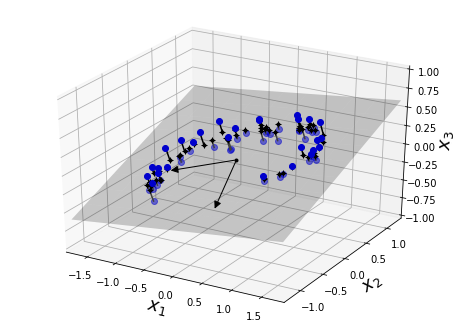

In [3]:
fig = plt.figure(figsize=(8, 5.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

plt.show()

注意到所有训练实例的分布都贴近一个平面：这是高维(3D)空间的较低维(2D)子空间。现在，如果我们将每个训练实例垂直投影到这个子空间上(就像将短线连接到平面的点所表示的那样)，我们就可以得到如`图8-3`所示的新2D数据集。铛铛铛！我们刚刚将数据集的维度从3D降低到了2D。请注意，坐标轴对应于新的特征$z_1$和$z_2$(平面上投影的坐标)。

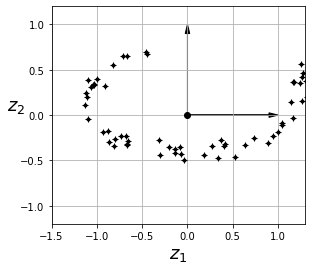

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
plt.show()

但是，投影并不总是降维的最佳方法。在很多情况下，子空间可能会扭曲和转动，比如`图8-4`所示的着名瑞士卷玩具数据集。

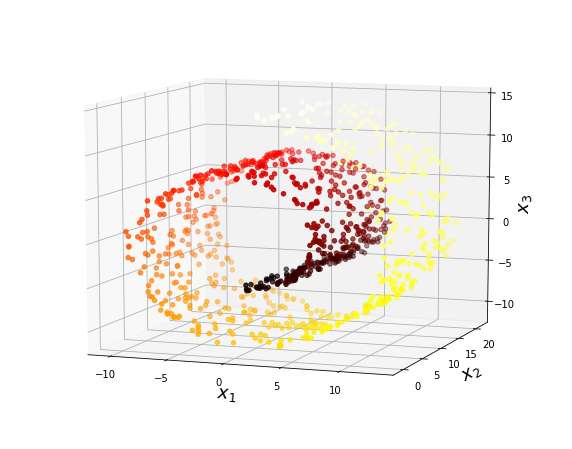

In [5]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

简单地将数据集投射到一个平面上(例如，直接丢弃$x_3$)会将瑞士卷的不同层叠在一起，如`图8-5`左侧所示。但是，你真正想要的是展开瑞士卷所获取到的类似`图8-5`右侧的2D数据集。

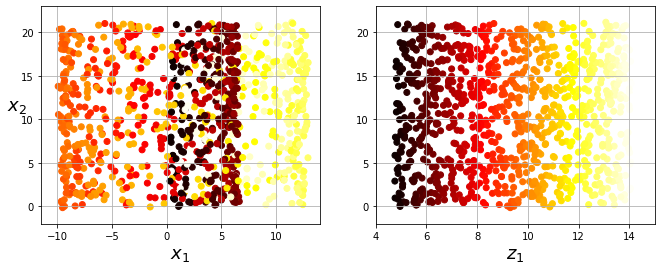

In [6]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

### 8.2.2 流形学习
瑞士卷一个是二维流形的例子。简而言之，二维流形是一种二维形状，它可以在更高维空间中弯曲或扭曲。更一般地，一个$d$维流形是类似于$d$维超平面的$n$维空间(其中$d<n$)的一部分。在我们瑞士卷这个例子中，$d=2，n=3$：它有些像2D平面，但是它实际上是在第三维中卷曲。

许多降维算法通过对训练实例所在的流形进行建模从而达到降维目的；这叫做`流形学习`。它依赖于`流形猜想`(manifold assumption)，也被称为`流形假设`(manifold hypothesis)，它认为大多数现实世界的高维数据集大都靠近一个更低维的流形。这种假设经常在实践中被证实。

让我们再回到MNIST数据集：所有手写数字图像都有一些相似之处。它们由连线组成，边界是白色的，大多是在图片中中间的，等等。如果你随机生成图像，只有一小部分看起来像手写数字。换句话说，如果您尝试创建数字图像，那么您的自由度远低于您生成任何随便一个图像时的自由度。这些约束往往会将数据集压缩到较低维流形中。

流形假设通常包含着另一个隐含的假设：你现在的手上的工作(例如分类或回归)，如果在流形的较低维空间中表示，那么它们会变得更简单。例如，在`图8-6`的第一行中，瑞士卷被分为两类：在三维空间中(图左上)，分类边界会相当复杂，但在二维展开的流形空间中(图右上)，分类边界是一条简单的直线。

但是，这个假设并不总是成立。例如，在`图8-6`的最下面一行，决策边界位于$x_1=5$(图左下)。这个决策边界在原始三维空间(一个垂直平面)看起来非常简单，但在展开的流形中却变得更复杂了(四个独立线段的集合)(图右下）。

简而言之，如果在训练模型之前降低训练集的维数，那训练速度肯定会加快，但并不总是会得出更好的训练效果；这一切都取决于数据集。

希望你现在对于维数爆炸以及降维算法如何解决这个问题有了一定的理解，特别是对流形假设提出的内容。本章的其余部分将介绍一些最流行的降维算法。

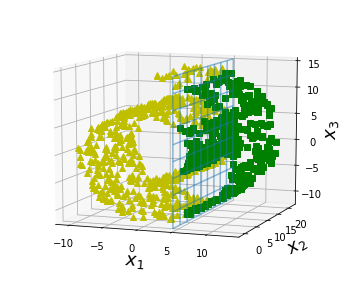

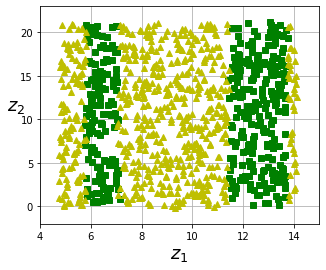

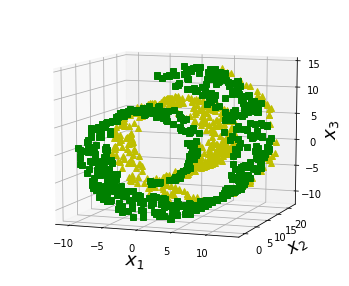

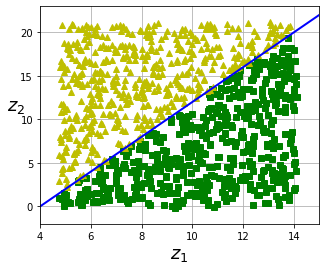

In [7]:
axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

## 8.3 主成分分析（PCA）
主成分分析(Principal Component Analysis)是目前为止最流行的降维算法。首先它找到接近数据集分布的超平面，然后将所有的数据都投影到这个超平面上，如下图所示。

### 8.3.1 保留(最大)方差
在将训练集投影到较低维超平面之前，您首先需要选择正确的超平面。例如`图8-7`左侧是一个简单的二维数据集，以及三个不同的轴(即一维超平面)。图右边是将数据集投影到每个轴上的结果。正如你所看到的，投影到实线上保留了最大方差，而在点线上的投影只保留了非常小的方差，投影到虚线上保留的方差则处于上述两者之间。

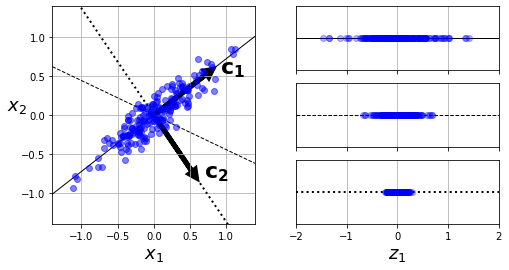

In [8]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

选择保持最大方差的轴看起来是合理的，因为它很可能比其他投影损失更少的信息。证明这种选择的另一种方法是，选择这个轴使得将原始数据集投影到该轴上的均方距离最小。这是就PCA背后的思想，相当简单。

### 8.3.2 主成分(Principle Componets)
PCA寻找训练集中可获得最大方差的轴。在`图8-7`中，它是一条实线。它还发现了一个与第一个轴正交的第二个轴，选择它可以获得最大的残差。在这个2D例子中，没有选择：就只有这条点线。但如果在一个更高维的数据集中，PCA也可以找到与前两个轴正交的第三个轴，以及与数据集中维数相同的第四个轴，第五个轴等。 定义第$i$个轴的单位矢量被称为第$i$个主成分(PC)。在`图8-7`中，第一个PC是$c_1$，第二个PC是$c_2$。在`图8-2`中，前两个PC用平面中的正交箭头表示，第三个PC与上述PC形成的平面正交（指向上或下）。

> **概述**
> 主成分的方向不稳定：如果您稍微打乱一下训练集并再次运行PCA，则某些新PC可能会指向与原始PC方向相反。但是，它们通常仍位于同一轴线上。在某些情况下，一对PC甚至可能会旋转或交换，但它们定义的平面通常保持不变。

那么如何找到训练集的主成分呢？幸运的是，有一种称为`奇异值分解`(SVD)的标准矩阵分解技术，可以将训练集矩阵$X$分解为三个矩阵$U$、$\sum$和$V^T$的点积，其中$V^T$包含我们想要的所有主成分，如`公式8-1`所示。

+ $\displaystyle\begin{equation} V = \left ( \begin{matrix} | & | & \cdots & | \\ c_1 & c_2 & \cdots & c_n \\ | & | & \cdots & | \end{matrix} \right ) \end{equation}$

下面的Python代码使用了Numpy提供的`svd()`函数获得训练集的所有主成分，然后提取前两个PC:

In [9]:
X_centered = X - X.mean(axis=0) 
U, s, Vt = np.linalg.svd(X_centered) 
c1 = Vt.T[:, 0] 
c2 = Vt.T[:, 1]

> **警告**
> PCA假定数据集以原点为中心。正如我们将看到的，Scikit-Learn的PCA类负责为您的数据集中心化处理。但是，如果您自己实现PCA(如前面的示例所示)，或者如果您使用其他库，不要忘记首先要先对数据做中心化处理。

### 8.3.3 投影到d维空间
一旦确定了所有的主成分，你就可以通过将数据集投影到由前$d$个主成分构成的超平面上，从而将数据集的维数降至$d$维。选择这个超平面可以确保投影将保留尽可能多的方差。例如，在`图8-2`中，3D数据集被投影到由前两个主成分定义的2D平面，保留了大部分数据集的方差。因此，2D投影看起来非常像原始3D数据集。

为了将训练集投影到超平面上，可以简单地通过计算训练集矩阵$X$和$W_d$的点积，$W_d$定义为包含前$d$个主成分的矩阵(即由$V^T$的前$d$列组成的矩阵)，如`公式8-2`所示。

+ $X_{d-proj} = XW_d$

下面的Python代码将训练集投影到由前两个主成分定义的超平面上：

In [10]:
W2=Vt.T[:,:2]
X2D=X_centered.dot(W2)

好了你已经知道这个东西了！你现在已经知道如何给任何一个数据集降维而又能尽可能的保留原数据集的方差了。

### 8.3.4 使用Scikit-Learn
Scikit-Learn的PCA类使用SVD分解来实现，就像我们之前做的那样。以下代码应用PCA将数据集的维度降至两维(请注意，它会自动处理数据的中心化)：

In [11]:
# 准备3d数据集
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

pca = PCA(n_components = 2) 
X2D = pca.fit_transform(X)

将PCA转化器应用于数据集后，可以使用`components_`访问每一个主成分(注意，它返回以PC作为水平向量的矩阵，因此，如果我们想要获得第一个主成分则可以写成`pca.components_.T[:,0]`)。

### 8.3.5 方差解释率(Explained Variance Ratio)
另一个非常有用的信息是每个主成分的方差解释率，可通过`explained_variance_ratio_`变量获得。它表示位于每个主成分轴上的数据集方差的比例。例如，让我们看一下`图8-2`中表示的三维数据集前两个分量的方差解释率：

In [12]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

这表明，`84.2%`的数据集方差位于第一轴，`14.6%`的方差位于第二轴。第三轴的这一比例不到`1.2％`，因此可以认为它可能没有包含什么信息。

### 8.3.6 选择正确的维度
通常我们倾向于选择加起来到方差解释率能够达到足够占比(例如`95%`)的维度的数量，而不是任意选择要降低到的维度数量。当然，除非您正在为数据可视化而降低维度 -- 在这种情况下，您通常希望将维度降低到2或3。

下面的代码在不降维的情况下进行PCA，然后计算出保留训练集方差`95%`所需的最小维数：

In [13]:
pca=PCA()
pca.fit(X)
cumsum=np.cumsum(pca.explained_variance_ratio_)
d=np.argmax(cumsum>=0.95)+1
d

2

你可以设置`n_components=d`并再次运行PCA。但是，有一个更好的选择：不指定你想要保留的主成分个数，而是将`n_components`设置为`0.0`到`1.0`之间的浮点数，表明您希望保留的方差比率：

In [14]:
pca=PCA(n_components=0.95)
X_reduced=pca.fit_transform(X)

另一种选择是画出方差解释率关于维数的函数(简单地绘制cumsum；参见`图8-8`)。曲线中通常会有一个肘部，方差解释率停止快速增长。您可以将其视为数据集的真正的维度。在这种情况下，您可以看到将维度降低到大约100个维度不会失去太多的可解释方差。

<img src="images/08_08.png" style="width:500px;"/>

### 8.3.7 PCA 压缩
显然，在降维之后，训练集占用的空间要少得多。例如，尝试将PCA应用于MNIST数据集，同时保留95%的方差。你应该发现每个实例只有150多个特征，而不是原来的784个特征。因此，尽管大部分方差都保留下来，但数据集现在还不到其原始大小的20%！这是一个合理的压缩比率，您可以看到这可以如何极大地加快分类算法(如SVM分类器)的速度。

通过应用PCA投影的逆变换，也可以将缩小的数据集解压缩回784维。当然这并不会返回给你最原始的数据，因为投影丢失了一些信息(在5％的方差内)，但它可能非常接近原始数据。原始数据和重构数据之间的均方距离(压缩然后解压缩)被称为`重构误差`(reconstruction error)。例如，下面的代码将MNIST数据集压缩到154维，然后使用`inverse_transform()`方法将其解压缩回784维。`图8-9`显示了原始训练集(左侧)的几位数字在压缩并解压缩后(右侧)的对应数字。您可以看到有轻微的图像质量降低，但数字仍然大部分完好无损。

In [15]:
# 下载MNIST数据集
from six.moves import urllib
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [16]:
X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [17]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

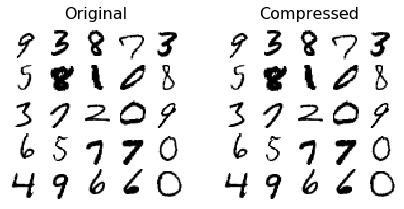

In [18]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
X_reduced = pca.fit_transform(X_train) 
X_recovered = pca.inverse_transform(X_reduced)

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)
plt.show()

逆变换的公式如`公式8-3`所示：

+ $X_{recovered} = X_{d-proj}W_{d}^{T}$

### 8.3.8 随机PCA(Randomized PCA)
如果你将PCA模型的超参数`svd_solver`设置为`randomized`，Scikit-Learn将使用一种随机算法快速找到前$d$个主成分的近似值，这种算法称为`随机PCA`。它的计算复杂度是$O(m × d^2) + O(d^3)$，而不是$O(m × n^2) + O(n^3)$，所以当$d$远小于$n$时，它比之前的算法快得多。

In [19]:
rnd_pca = PCA(n_components=154, svd_solver='randomized') 
X_reduced = rnd_pca.fit_transform(X_train)

By default, svd_solver is actually set to "auto": Scikit-Learn automatically uses the randomized PCA algorithm if m or n is greater than 500 and d is less than 80% of m or n, or else it uses the full SVD approach. If you want to force Scikit-Learn to use full SVD, you can set the svd_solver hyperparameter to "full".

缺省情况下，超参数`svd_solver` 被设置为`auto`：在$m$和$n$大于500，并且$d$小于$m$或者$n$的80%时，Scikit-Learn自动选择随机PCA算法；否则，在全量数据集上应用SVD方法。将超参数`svd_solver` 被设置为`full`可以强迫Scikit-Learn使用全量SVD方法。

### 8.3.9 增量PCA(Incremental PCA)
先前的PCA实现的一个问题是它需要在内存中处理整个训练集以便SVD算法运行。幸运的是，我们已经开发了`增量PCA`(IPCA)算法：您可以将训练集分批，并一次只对一个批量使用IPCA算法。这对大型训练集非常有用，并且可以在线应用PCA(即在新实例到达时即时运行)。

下面的代码将MNIST数据集分成100个小批量(使用NumPy的`array_split()`函数)，并将它们提供给Scikit-Learn的`IncrementalPCA`类，以将MNIST数据集的维度降低到154维(就像以前一样)。请注意，您必须对每个最小批次调用`partial_fit()`方法，而不是对整个训练集使用`fit()`方法：

In [20]:
n_batches = 100 
inc_pca = IncrementalPCA(n_components=154) 

for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

或者，您可以使用`NumPy`的`memmap`类，它允许您操作存储在磁盘上二进制文件中的大型数组，就好像它完全在内存中；该类仅在需要时加载内存中所需的数据。由于增量PCA类在任何时间内仅使用数组的一小部分，因此内存使用量仍受到控制。这可以调用通常的`fit()`方法，如下面的代码所示：

```python
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches 
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size) 
inc_pca.fit(X_mm)
```

## 8.4 核PCA
在第5章中，我们讨论了核技巧，一种将实例隐式映射到非常高维空间(称为`特征空间`)的数学技术，让支持向量机可以应用于非线性分类和回归。回想一下，高维特征空间中的线性决策边界对应于原始空间中的复杂非线性决策边界。

事实证明，同样的技巧可以应用于PCA，从而可以执行复杂的非线性投影来降低维度。这就是所谓的`核PCA`(kPCA)。它通常能够很好地保留投影后的簇，有时甚至可以展开分布近似于扭曲流形的数据集。

例如，下面的代码使用Scikit-Learn的KernelPCA类来执行带有RBF核的kPCA(有关RBF核和其他核的更多详细信息，请参阅第5章)：

In [21]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

`图8-10`展示了使用线性核(等同于简单的使用PCA类)，RBF核，sigmoid核(Logistic)将瑞士卷降到2维。

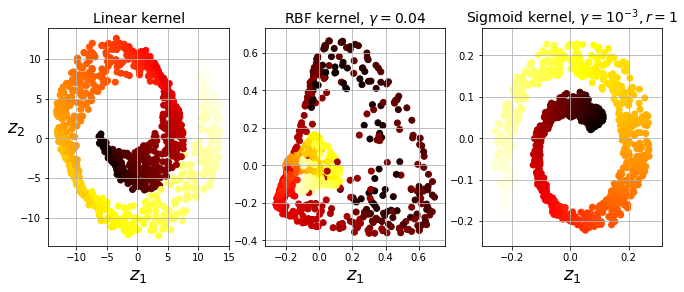

In [22]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

### 8.4.1 选择一种核并调整超参数
由于`kPCA`是无监督学习算法，因此没有明显的性能指标可以帮助您选择最佳的核方法和超参数值。但是，降维通常是监督学习任务(例如分类)的准备步骤，因此您可以简单地使用网格搜索来选择可以让该任务达到最佳表现的核方法和超参数。例如，下面的代码创建了一个两步的流水线，首先使用kPCA将维度降至两维，然后应用`Logistic回归`进行分类。然后它使用`GridSearchCV`为`kPCA`找到最佳的核和`gamma`值，以便在最后获得最佳的分类准确性：

In [23]:
clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="liblinear"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                 

你可以通过调用`best_params_`变量来查看使模型效果最好的核和超参数：

In [24]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


另一种完全为衡量非监督算法性能的方法，是选择产生最低重建误差的核和超参数。但是，重建并不像线性PCA那样容易。这里是原因：`图8-11`显示了原始瑞士卷3D数据集(左上角)，并且使用RBF核应用kPCA后生成的二维数据集(右上角)。由于核技巧，这在数学上等同于使用特征映射$\phi$将训练集映射到无限维特征空间(右下)，然后使用线性PCA将变换的训练集投影到2D。请注意，如果我们可以在缩减空间中对给定实例实现反向线性PCA步骤，则重构点将位于特征空间中，而不是位于原始空间中(例如，如图中由$x$表示的那样)。由于特征空间是无限维的，我们不能找出重建点，因此我们无法计算真实的重建误差。幸运的是，可以在原始空间中找到一个贴近重建点的点。这被称为`重建前图像`(reconstruction pre-image)。一旦你有这个前图像，你就可以测量其与原始实例的平方距离。然后，您可以选择最小化重建前图像错误的核和超参数。

<img src="images/08_11.png" style="width:500px;"/>

您可能想知道如何进行这种重建。一种解决方案是训练一个监督回归模型，将预计实例作为训练集，并将原始实例作为训练目标。如果您设置了`fit_inverse_transform = True`，Scikit-Learn将自动执行此操作，代码如下所示：

In [25]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True) 
X_reduced = rbf_pca.fit_transform(X) 
X_preimage = rbf_pca.inverse_transform(X_reduced)

> 默认条件下，`fit_inverse_transform = False`并且Kernel PCA没有`inverse_tranfrom()`方法。这种方法仅仅当`fit_inverse_transform = True`的情况下才会创建。

你可以计算重建前图像误差：

In [26]:
mean_squared_error(X, X_preimage)

32.786308795766125

现在你可以使用交叉验证的方格搜索来寻找可以最小化重建前图像误差的核方法和超参数。

## 8.5 LLE
`局部线性嵌入`(Locally Linear Embedding)是另一种非常有效的非线性降维(NLDR)方法。这是一种流形学习技术，不依赖于像以前算法那样的投影。简而言之，LLE首先测量每个训练实例与其最近邻(c.n.)之间的线性关系，然后寻找能最好地保留这些局部关系的训练集的低维表示(稍后会详细介绍)。这使得它特别擅长展开扭曲的流形，尤其是在没有太多噪音的情况下。

例如，以下代码使用Scikit-Learn的`LocallyLinearEmbedding`类来展开瑞士卷。得到的二维数据集如`图8-12`所示。正如您所看到的，瑞士卷被完全展开，实例之间的距离保存得很好。但是，距离不能在较大范围内保留的很好：展开的瑞士卷的左侧被挤压，而右侧的部分被拉长。尽管如此，LLE在对流形建模方面做得非常好。

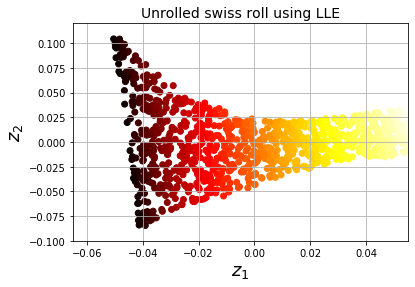

In [27]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

现在了解一下`LLE`的工作原理：首先，对于每个训练实例$x^{(i)}$，`LLE`算法识别其最近的$k$个邻居(在前面的代码中$k=10$)，然后尝试将$x^{(i)}$重构为这些邻居的线性函数。更具体地，找到权重$w_{i,j}$，从而使$x^{(i)}$和$\displaystyle\sum_{j=1}^{m}w_{i,j} x^{(j)}$之间的平方距离尽可能的小，假设如果$x^{(j)}$不是$x^{(i)}$的$k$个最近邻时$w_{i,j}=0$。因此，`LLE`的第一步是`方程8-4`中描述的约束优化问题，其中$W$是包含所有权重$w_{i,j}$的权重矩阵。第二个约束简单地对每个训练实例$x^{(i)}$的权重进行归一化。

- $\displaystyle\widehat{W} = \mathop{\arg\min}_{w} \sum_{i=1}^{m}\bigg(\mathrm{x}^{(i)}-\sum_{j=1}^{m}w_{i,j}\mathrm{x}^{(j)}\bigg)^2$
- $\displaystyle\begin{equation}\mathrm{subject \  to}= \left\{\begin{array}{l} w_{i,j}=0 & \mathrm{if} \ x^{(j)} \mathrm{is \ not \ one \ of \ the} \ k \ \mathrm{c.n. of} \ x^{(i)} \\ \sum_{j=1}^{m} w_{i,j}=1 & \mathrm{for} \  i = 1, 2, ⋯, m \end{array} \right. \end{equation}$

在这步之后，权重矩阵$\widehat{W}$(包含权重$\hat{w_{i,j}}$)对训练实例的线形关系进行编码。现在第二步是将训练实例投影到一个$d$维空间($d < n$)中去，同时尽可能的保留这些局部关系。如果$z^{(i)}$是$x^{(i)}$在这个$d$维空间的图像，那么我们想要$z^{(i)}$和$\sum_{j=1}^{m}\hat{w_{i,j}}\ z^{(j)}$之间的平方距离尽可能的小。这个想法让我们提出了`公式8-5`中的非限制性优化问题。它看起来与第一步非常相似，但我们要做的不是保持实例固定并找到最佳权重，而是恰相反：保持权重不变，并在低维空间中找到实例图像的最佳位置。请注意，$Z$是包含所有$z^{(i)}$的矩阵。

- $\displaystyle\widehat{Z} = \mathop{\arg\min}_{Z} \sum_{i=1}^{m}\bigg(z^{(i)}-\sum_{j=1}^{m}\hat{w}_{i,j}z^{(j)}\bigg)^2$

Scikit-Learn的LLE实现具有如下的计算复杂度：查找$k$个最近邻为$O(m\ \log{(m)}\ n\ \log{(k)})$，优化权重为$O(m\ n\ k^3)$，建立低维表示为$O(d m^2)$。不幸的是，最后一项$m^2$使得这个算法在处理大数据集的时候表现较差。

## 8.6 其他降维方法
还有很多其他的降维方法，Scikit-Learn支持其中的好几种。这里是其中最流行的：
+ `多维缩放`(MDS)在尝试保持实例之间距离的同时降低了维度(参见`图8-13`)
+ `Isomap`通过将每个实例连接到最近的邻居来创建图形，然后在尝试保持实例之间的测地距离时降低维度。
+ `t-分布随机邻域嵌入`(t-Distributed Stochastic Neighbor Embedding，t-SNE)可以用于降低维度，同时试图保持相似的实例临近并将不相似的实例分开。它主要用于可视化，尤其是用于可视化高维空间中的实例(例如，可以将MNIST图像降维到2D可视化)
+ `线性判别分析`(Linear Discriminant Analysis，LDA)实际上是一种分类算法，但在训练过程中，它会学习类之间最有区别的轴，然后使用这些轴来定义用于投影数据的超平面。LDA 的好处是投影会尽可能地保持各个类之间距离，所以在运行另一种分类算法(如`SVM`分类器)之前，LDA是很好的降维技术

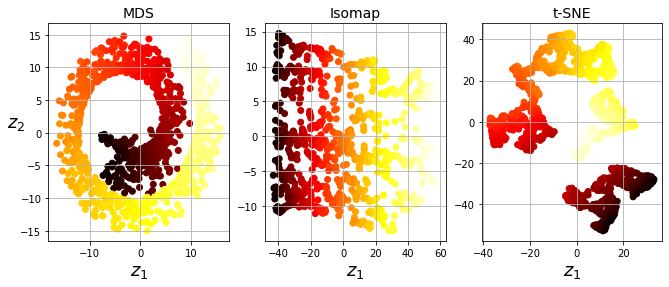

In [28]:
mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles, (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()